In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import hdbscan as HD
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tunning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tunning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
df_hdbscan_clustering = pd.read_csv("data/tunning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering.head()

voisinage  min_cluster_size     distance  K  silhouette  Cal-Harabasz  \
0         44                10  precomputed  3    0.368642           NaN   
1         27                13  precomputed  3    0.380373           NaN   
2         27                14  precomputed  3    0.380373           NaN   
3         12                10  precomputed  3    0.377630           NaN   
4          8                10  precomputed  3    0.347484           NaN   

       DBCV  non_classes  perplexity wordEmbedding docEmbedding docEmbedding2  
0  0.230799          474         NaN          cbow          WMD      Distance  
1  0.230429          427         NaN          cbow          WMD      Distance  
2  0.230429          427         NaN          cbow          WMD      Distance  
3  0.197934          427         NaN          cbow          WMD      Distance  
4  0.197650          551         NaN          cbow          WMD      Distance

# Avant Tsne

## Moyenne embedding

In [6]:
df_hdbscan_moy = df_hdbscan_clustering.loc[(df_hdbscan_clustering["docEmbedding"] == "Moyenne") & (df_hdbscan_clustering["perplexity"].isna())].reset_index()

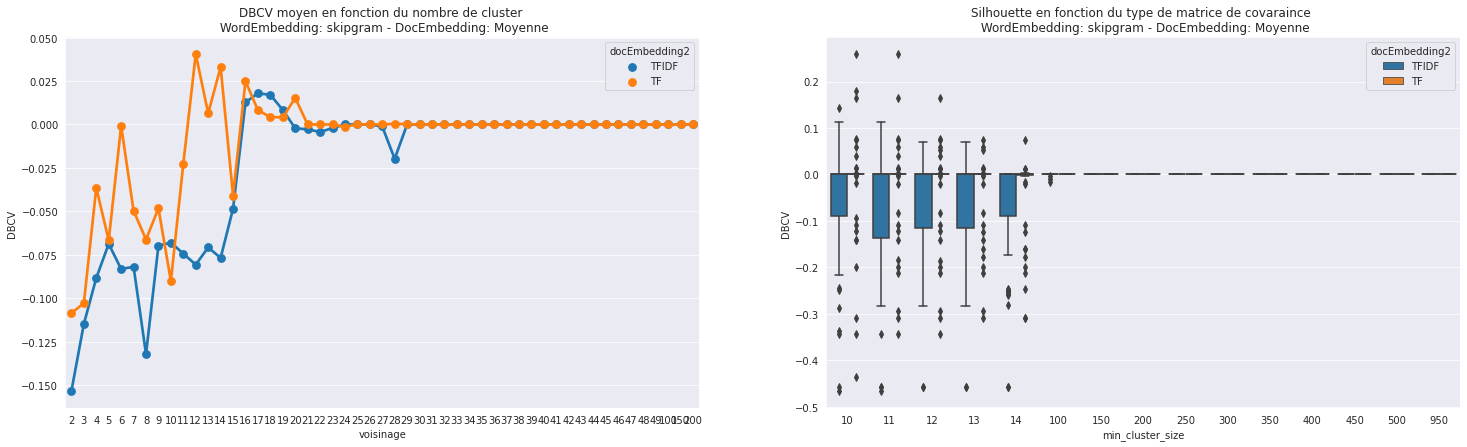

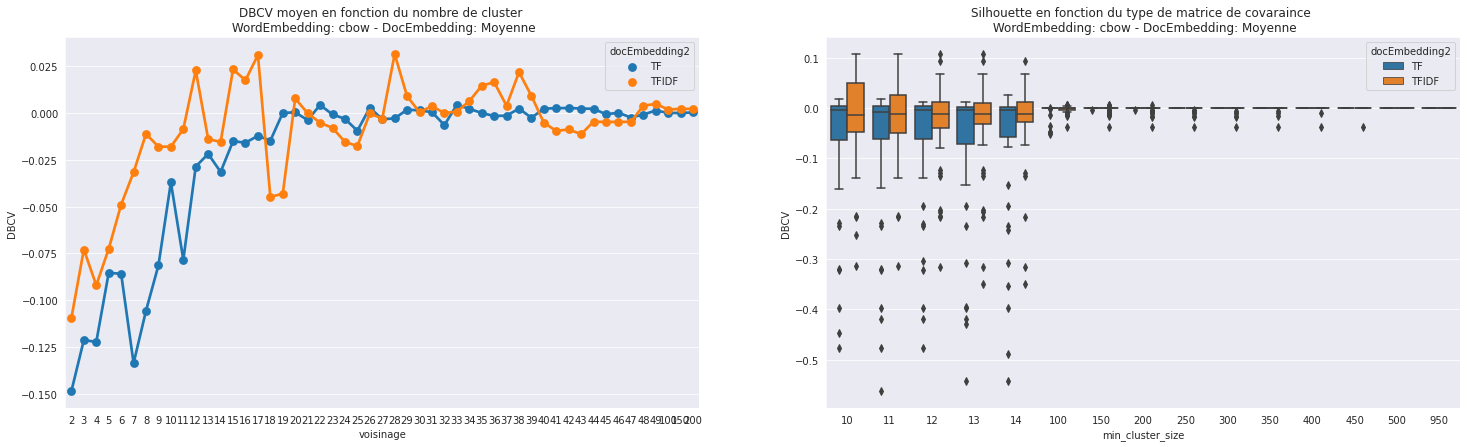

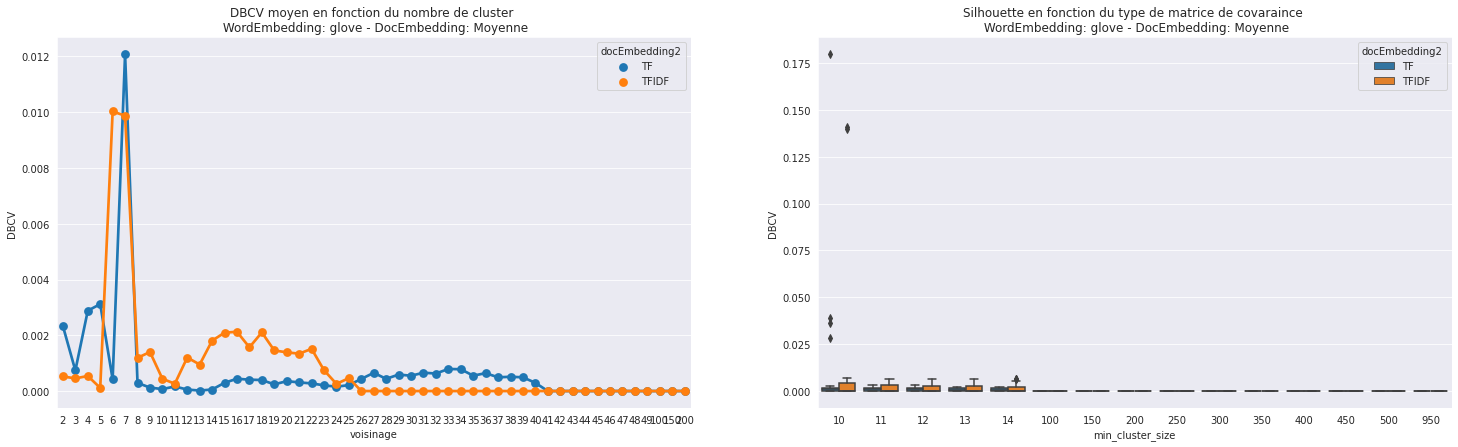

In [8]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_hdbscan_moy[df_hdbscan_moy["wordEmbedding"]==modele],y="DBCV",x="voisinage",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"DBCV moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data = df_hdbscan_moy[df_hdbscan_moy["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_hdbscan_moy[df_hdbscan_moy["wordEmbedding"]==modele],y="DBCV",x="min_cluster_size",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"Silhouette en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data=df_hdbscan_moyTF,y="silhouette",x="initialisation",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="initialisation"))
    plt.show()

In [9]:
df_hdbscan_moy.loc[df_hdbscan_moy.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance  K  silhouette  \
3060  42840         17                11  euclidean  3   -0.140781   
0     10710          7                10  euclidean  3    0.162009   
3825  48195         12                10  euclidean  3    0.545563   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
3060    976.835164  0.107140         5641         NaN          cbow   
0        30.999241  0.179658         1406         NaN         glove   
3825    689.088796  0.259002          388         NaN      skipgram   

     docEmbedding docEmbedding2  
3060      Moyenne         TFIDF  
0         Moyenne            TF  
3825      Moyenne            TF

## WMD

In [10]:
df_hdbscan_wmd = df_hdbscan_clustering.loc[(df_hdbscan_clustering["docEmbedding"] == "WMD") & (df_hdbscan_clustering["perplexity"].isna())].reset_index()

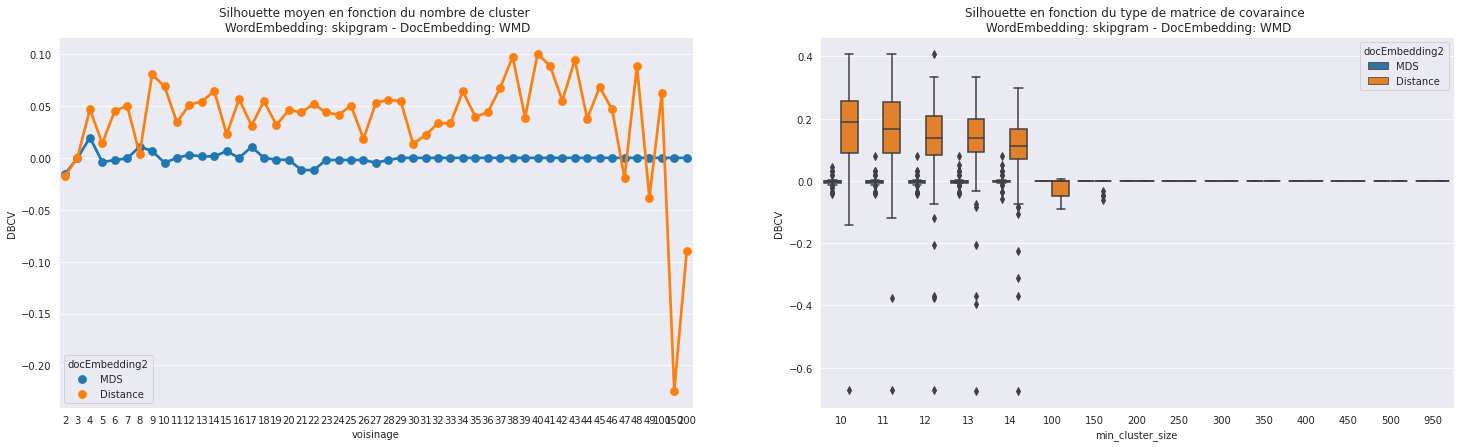

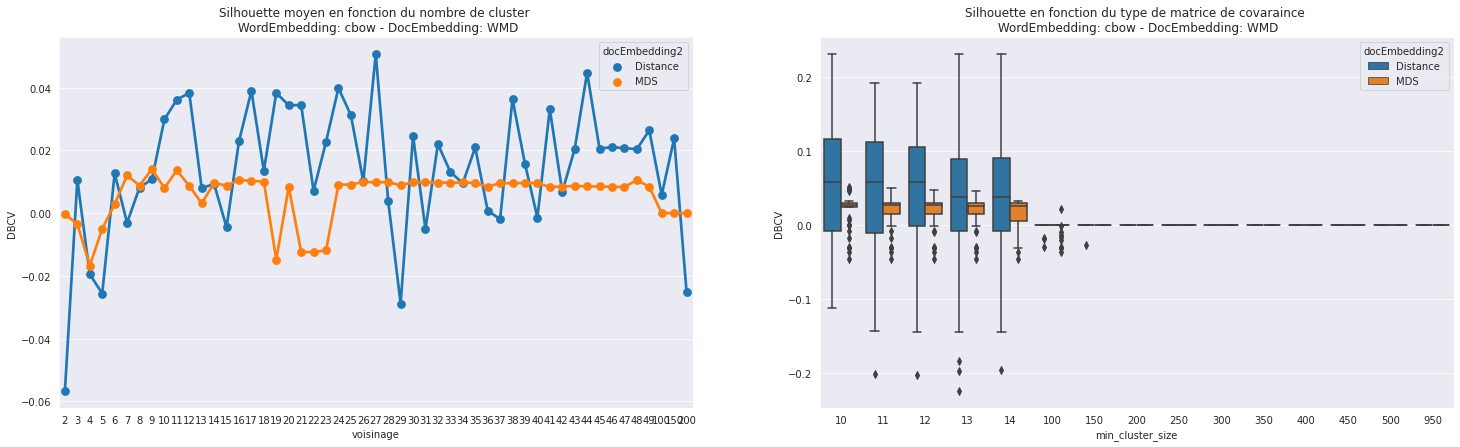

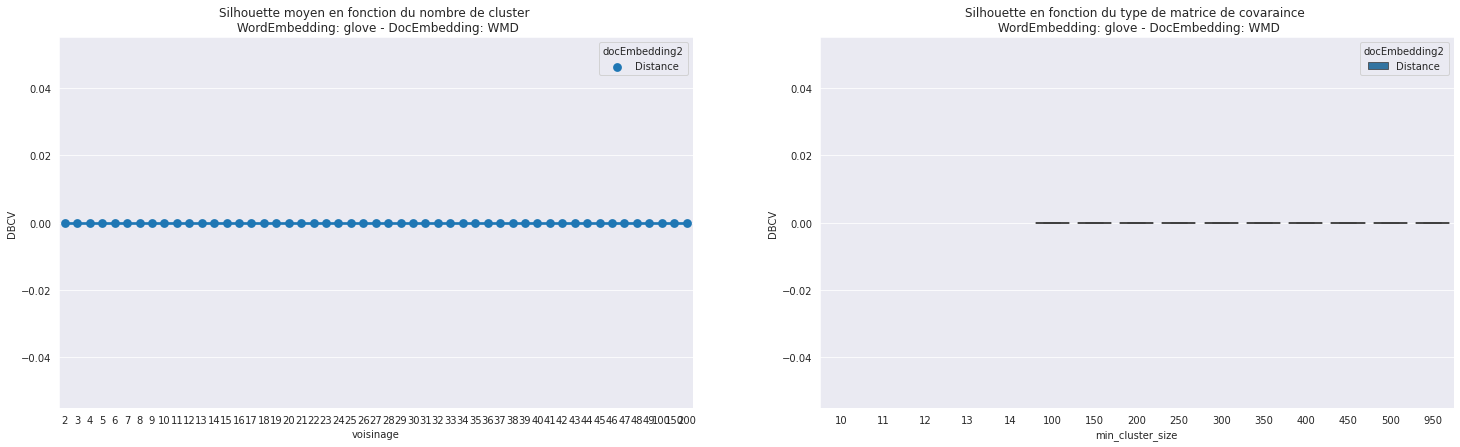

In [11]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_hdbscan_wmd[df_hdbscan_wmd["wordEmbedding"]==modele],y="DBCV",x="voisinage",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"Silhouette moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data = df_hdbscan_moy[df_hdbscan_moy["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_hdbscan_wmd[df_hdbscan_wmd["wordEmbedding"]==modele],y="DBCV",x="min_cluster_size",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"Silhouette en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data=df_hdbscan_moyTF,y="silhouette",x="initialisation",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="initialisation"))
    plt.show()

In [13]:
df_hdbscan_wmd.loc[df_hdbscan_wmd.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance  K  silhouette  \
0         0         44                10  precomputed  3    0.368642   
765    5355          2               150  precomputed  1         NaN   
3060  53550         43                11  precomputed  3    0.318635   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
0              NaN  0.230799          474         NaN          cbow   
765            NaN  0.000000         9501         NaN         glove   
3060           NaN  0.407641          378         NaN      skipgram   

     docEmbedding docEmbedding2  
0             WMD      Distance  
765           WMD      Distance  
3060          WMD      Distance

# Avec TSNE

## Moyenne

In [14]:
df_hdbscan_moy2 = df_hdbscan_clustering.loc[(df_hdbscan_clustering["docEmbedding"] == "Moyenne") & (df_hdbscan_clustering["perplexity"].notna())].reset_index()

In [15]:
df_hdbscan_moy2.loc[df_hdbscan_moy2.groupby(["wordEmbedding","docEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance    K  silhouette  \
17595  42075         32               450  euclidean    4   -0.202506   
12240  30600          7                10  euclidean  222   -0.678185   
23715  49725         28                10  euclidean   67   -0.241299   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
17595   1656.990326  0.179336         5538       200.0          cbow   
12240     52.858622  0.217866         4825       150.0         glove   
23715    161.490846  0.208799         5039        75.0      skipgram   

      docEmbedding docEmbedding2  
17595      Moyenne            TF  
12240      Moyenne         TFIDF  
23715      Moyenne            TF

## WMD

In [16]:
df_hdbscan_wmd2 = df_hdbscan_clustering.loc[(df_hdbscan_clustering["docEmbedding"] == "WMD") & (df_hdbscan_clustering["perplexity"].notna())].reset_index()

In [17]:
df_hdbscan_wmd2.loc[df_hdbscan_wmd2.groupby(["wordEmbedding","docEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance   K  silhouette  \
1530    2295        200               100  euclidean   6   -0.269958   
4590    6120         15                12  euclidean  77   -0.269096   
22185  58140         20                10  euclidean  46   -0.667071   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
1530     753.185680  0.147703         5828       100.0          cbow   
4590     106.946867  0.155147         5476        50.0         glove   
22185    277.378904  0.135689         4862       200.0      skipgram   

      docEmbedding docEmbedding2  
1530           WMD      Distance  
4590           WMD      Distance  
22185          WMD      Distance

# Plot ScatterPlot

In [28]:
def plot_hdbscan(df_hdbscan,dict_embedding,hdbscan_metric="silhouette",first_reduce=False,modele="cbow",typeDocEmbedding = "Moyenne"):
    best_model = df_hdbscan.loc[df_hdbscan.groupby(["wordEmbedding"])[hdbscan_metric].idxmin()] if hdbscan_metric == "BIC" else df_hdbscan.loc[df_hdbscan.groupby(["wordEmbedding"])[hdbscan_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"


        doc_embedding = dict_embedding[modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)

        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])

        clust_model = HD.HDBSCAN(min_cluster_size=int(best_model["min_cluster_size"].values[0]), metric = best_model["distance"].values[0],min_samples=int(best_model["voisinage"].values[0]))
        
        hdbscan_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]
        labels = clust_model.fit_predict(np.array(hdbscan_data).astype(np.float64))

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best {typeDocEmbedding} DocEmbedding Hdbscan Clustering based on {hdbscan_metric}"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reduced Before Clustering: {first_reduce}" 
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - DBCV: {round(best_model['DBCV'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

## WMD Embedding

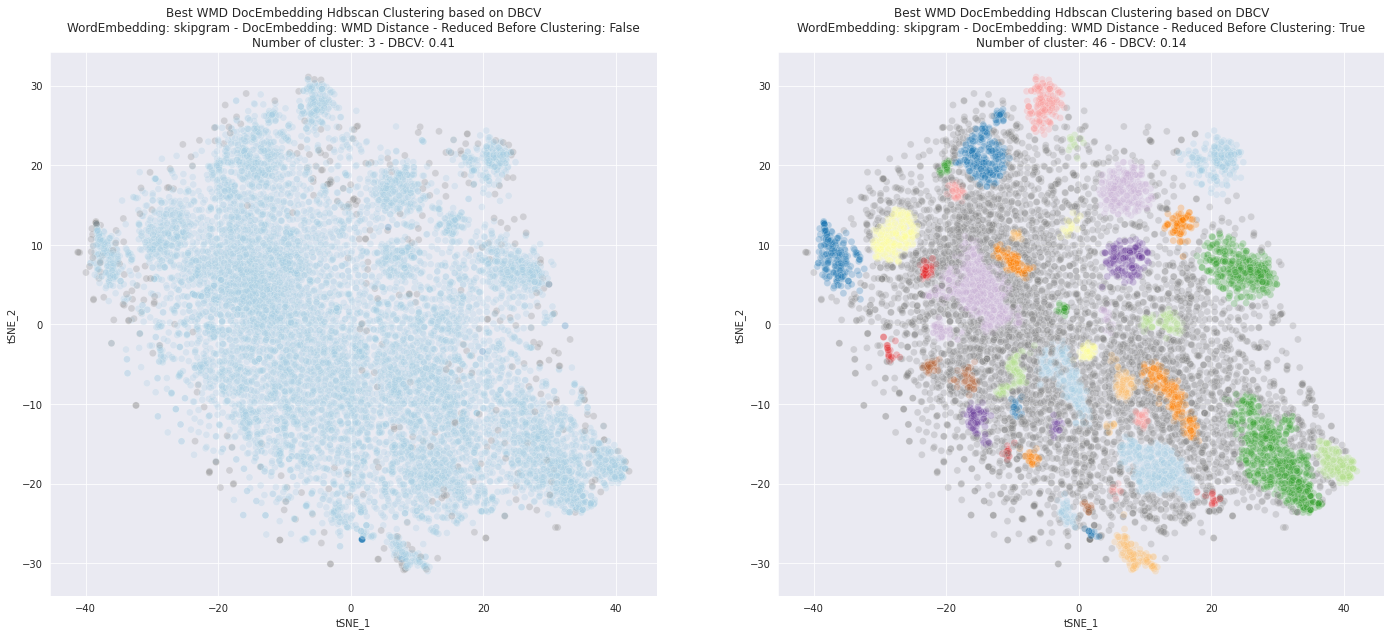

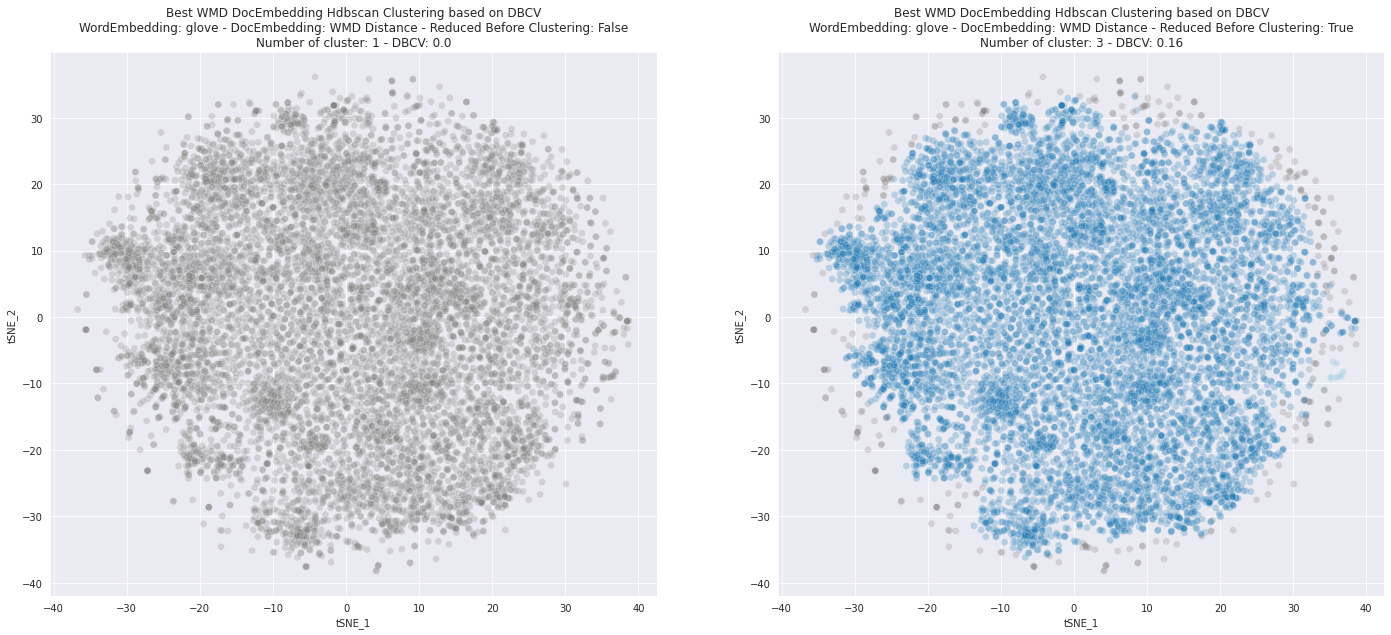

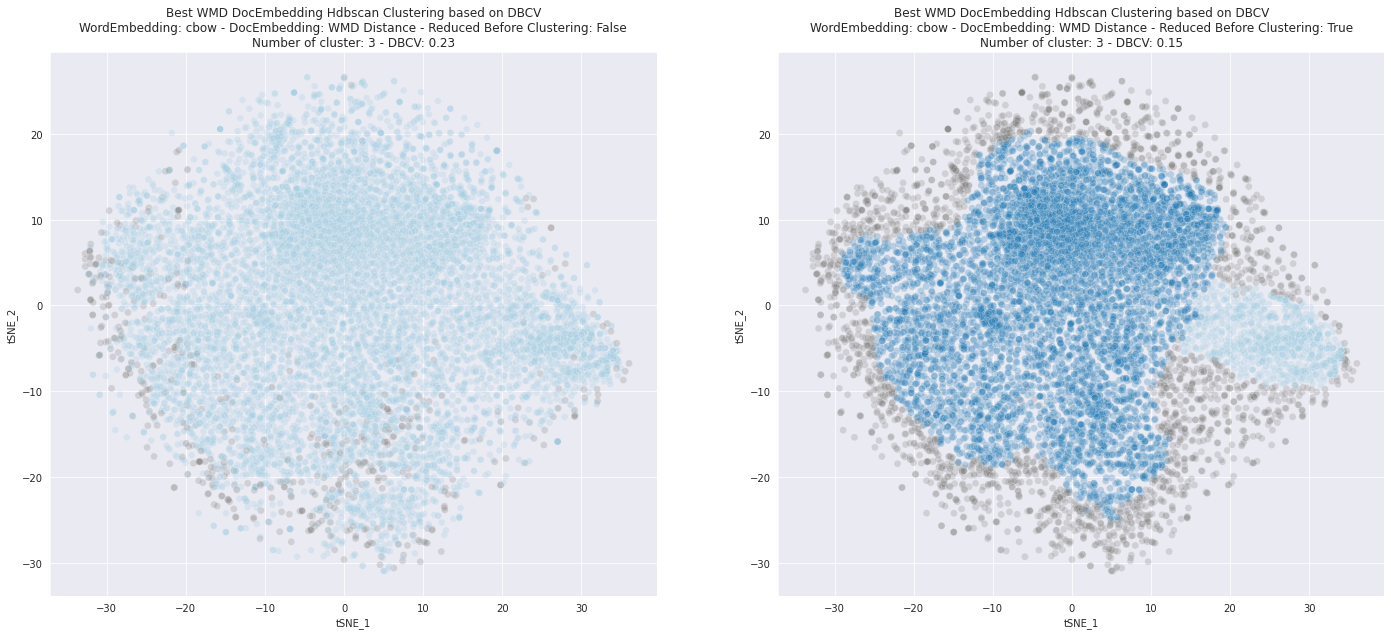

In [29]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_hdbscan(df_hdbscan_wmd,dict_wmd_embedding,hdbscan_metric="DBCV",first_reduce=False,modele=modele,typeDocEmbedding="WMD")
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_hdbscan(df_hdbscan_wmd2,dict_wmd_embedding,hdbscan_metric="DBCV",first_reduce=True,modele=modele,typeDocEmbedding = "WMD")

    #Plot
    plt.figure(figsize = (50,10))
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    plt.show()

## Moyenne Embedding

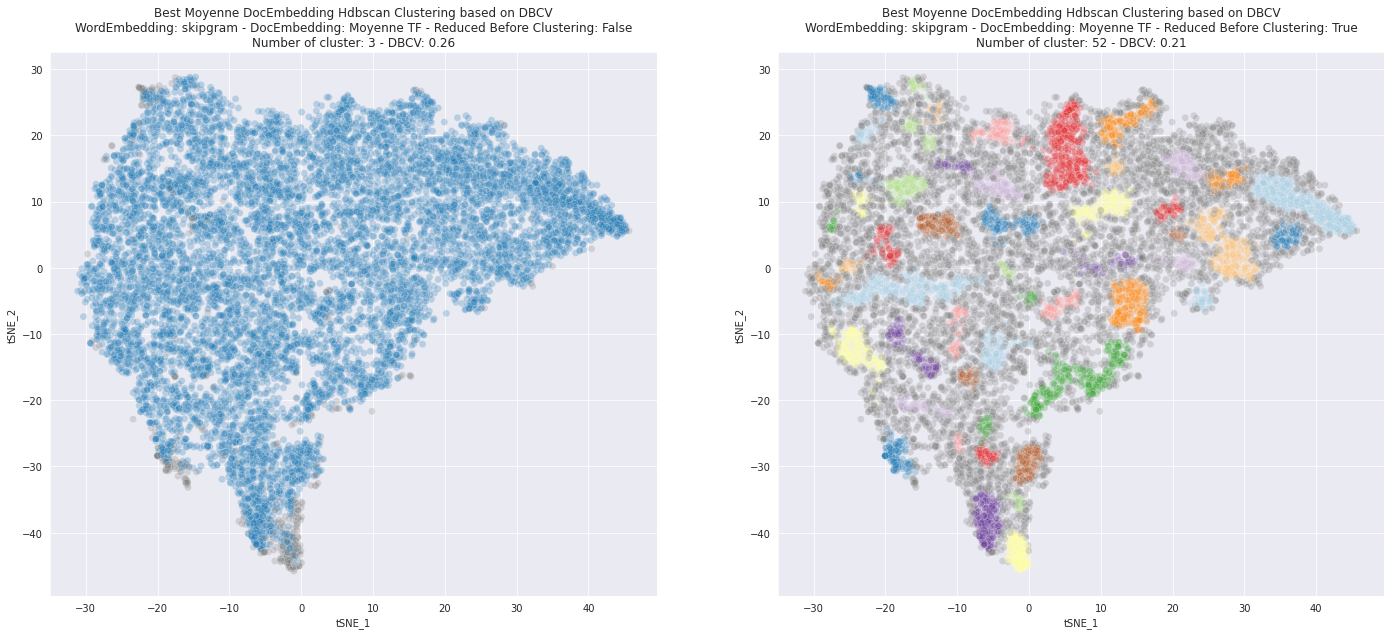

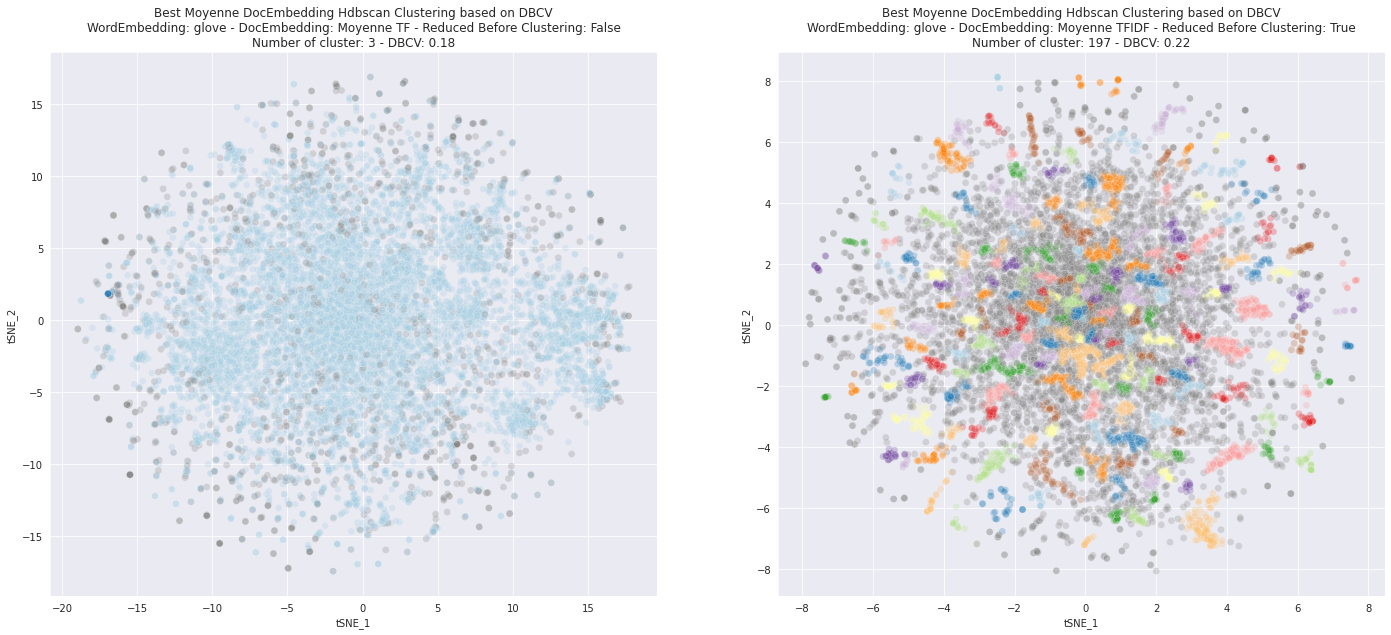

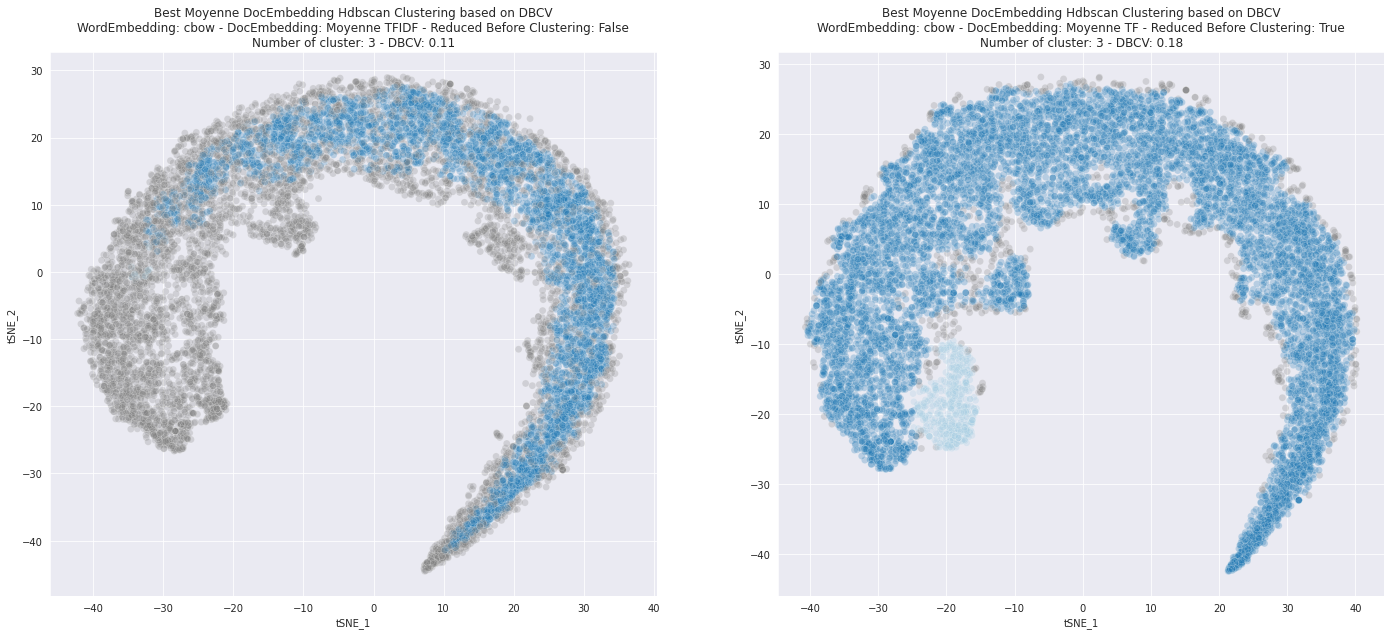

In [31]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_hdbscan(df_hdbscan_moy,dict_moy_embedding,hdbscan_metric="DBCV",first_reduce=False,modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_hdbscan(df_hdbscan_moy2,dict_moy_embedding,hdbscan_metric="DBCV",first_reduce=True,modele=modele)

    #Plot
    plt.figure(figsize = (50,10))
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")

    plt.show()